<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/lupis30puc-update-3/Yelp_polarity_trainning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp dataset on kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset)

12,993 samples from the Yelp Dataset Challenge 2020. 
Divided on train, validation and test subsets. 
Their corresponding sizes are: 10,394 train samples, 1,949 validation samples and 650 test samples.


Tutorial on which I support: 
[BERT Fine-Tunning](http://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification)
[Colab: BERT for sequential classification](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=DEfSbAA4QHas)


In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 12.9MB/s 
     |████████████████████████████████| 2.9MB 48.5MB/s 
     |████████████████████████████████| 890kB 55.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=999bccb94f595b486396625965b4c9e7e0887d3be52a471061b9482814ffbf8e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Set up

## GPU

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading the pre-processed dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import re

In [6]:
train_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_train_10394.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_validation_1949.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_650.pkl')

In [7]:
train_df.head()

,text,label
11349,second best pool in las vegas pay the commit t...,1
12582,we went there on a tuesday night in jan the we...,0
4547,my experience duplicates all other above below...,0
11873,mmmmmmr sushi this was the place i lost my sus...,1
12416,it is a little off the strip but they provide ...,1


reset index for all datasets:

In [8]:
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.head()

,text,label
0,second best pool in las vegas pay the commit t...,1
1,we went there on a tuesday night in jan the we...,0
2,my experience duplicates all other above below...,0
3,mmmmmmr sushi this was the place i lost my sus...,1
4,it is a little off the strip but they provide ...,1


Extract the tokenized texts and labels

In [9]:
# Get the lists of sentences and their labels.
train_x = train_df.text.values
train_y = train_df.label.values

val_x = validation_df.text.values
val_y = validation_df.label.values

test_x = test_df.text.values
test_y = test_df.label.values

# BERT

## BERT Tokenizer

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [12]:
def get_inputs_ids_mask(reviews, labels):
  %%time
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in reviews:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 150,           # Pad & truncate all sentences. 
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', reviews[0])
  print('Token IDs:', input_ids[0])
  return input_ids, attention_masks, labels

In [13]:
train_ii, train_masks, train_labels = get_inputs_ids_mask(train_x, train_y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Original:  second best pool in las vegas pay the commit to being here all day and drink the overpriced drinks while s and s hits are blast from the speakers they won t let you bring in your own alcohol they are nice about it but they do check and the pools are fun and creative there s one for kids especially and there s one for adults as well as a water slide we did the massage at the spa in the flamingo pretty outstanding 
Token IDs: tensor([  101,  2117,  2190,  4770,  1999,  5869,  7136,  3477,  1996, 10797,
         2000,  2108,  2182,  2035,  2154,  1998,  4392,  1996,  2058, 18098,
         6610,  2094,  8974,  2096,  1055,  1998,  1055,  4978,  2024,  8479,
         2013,  1996,  7492,  2027,  2180,  1056,  2292,  2017,  3288,  1999,
         2115,  2219,  6544,  2027,  2024,  3835,  2055,  2009,  2021,  2027,
         2079,  4638,  1998,  1996, 12679,  2024,  4569,  1998,  5541,  2045,
         1055,  2028,  2005, 

In [14]:
val_ii, val_masks, val_labels = get_inputs_ids_mask(val_x, val_y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Original:  first off the order taker messed up my order i didn t pay much attention when i first paid but after i looked at my slip although no way should have it been a mix up because when i said mac jr that sounds nowhere near a grand mac which is what i was charged for anyway fixed that without much trouble then the lady calls out order which was my cancelled order however she really wanted to say the order before mine i don t know how you mix that up orders not at all similar she then calls out again but this time it has the grand mac on it i informed her of the mistake and she fairly quickly turned around and got the mac jr on there however she rudely set the tray down and oh by the way no apology most mcdonalds i ve been to have improved customer service this one has a way to go there one additional thing though is the fries were undercooked compared to other mcdonalds they were barely cooked they tasted ok but not c

In [15]:
test_ii, test_masks, test_labels = get_inputs_ids_mask(test_x, test_y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Original:  after reading all the great reviews we thought we d give compadres a try for lunch we weren t disappointed we found the decor classy with quality furnishings unlike some other typical mexican restaurants we were greeted warmly and shown to a window booth chips two types of salsa were delivered promptly the menu has much to choose from i chose the lunch special with a choice of two smaller entrees the grilled chicken enchilada with mole sauce was excellent but even better was the chicken chimichanga it was accompanied by sides of rice and re fried beans everything seemed fresh and homemade the restaurant is staffed by i believe family members from mexico leading to my only negative comment there was a slight language barrier communicating our order all in all a quality lunch experience a restaurant we ll likely return to considering the other interesting offerings 
Token IDs: tensor([  101,  2044,  3752,  2035,  

Creating tensor Datasets

In [16]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_ii, train_masks, train_labels)
val_dataset = TensorDataset(val_ii, val_masks, val_labels)
test_dataset = TensorDataset(test_ii, test_masks, test_labels)

In [17]:
# Save the tensorDatasets
torch.save(train_dataset, '/content/drive/MyDrive/Yelp/sample_yelp_tensors/_train_150')
torch.save(val_dataset, '/content/drive/MyDrive/Yelp/sample_yelp_tensors/_validation_150')
torch.save(test_dataset, '/content/drive/MyDrive/Yelp/sample_yelp_tensors/_test_150')

In [18]:
train_dataset[0]

(tensor([  101,  2117,  2190,  4770,  1999,  5869,  7136,  3477,  1996, 10797,
          2000,  2108,  2182,  2035,  2154,  1998,  4392,  1996,  2058, 18098,
          6610,  2094,  8974,  2096,  1055,  1998,  1055,  4978,  2024,  8479,
          2013,  1996,  7492,  2027,  2180,  1056,  2292,  2017,  3288,  1999,
          2115,  2219,  6544,  2027,  2024,  3835,  2055,  2009,  2021,  2027,
          2079,  4638,  1998,  1996, 12679,  2024,  4569,  1998,  5541,  2045,
          1055,  2028,  2005,  4268,  2926,  1998,  2045,  1055,  2028,  2005,
          6001,  2004,  2092,  2004,  1037,  2300,  7358,  2057,  2106,  1996,
         21881,  2012,  1996, 12403,  1999,  1996, 19091,  2080,  3492,  5151,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially. FROM THE 2ND DIVISION
            batch_size = batch_size # Evaluate with this batch size.
        )

In [20]:
%%time
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. # It can be increased for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 11.4 s, sys: 2.79 s, total: 14.2 s
Wall time: 20.4 s


optimizer

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5 # A TEST WITH MORE EPOCHS SHOULD BE DONE, AT LEAST 7

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [23]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

training

In [25]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# Training

---



In [26]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss_logits_ = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = loss_logits_[0]
        logits = loss_logits_[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss_logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = loss_logits[0]
            logits = loss_logits[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:33.
  Batch    80  of    325.    Elapsed: 0:01:08.
  Batch   120  of    325.    Elapsed: 0:01:41.
  Batch   160  of    325.    Elapsed: 0:02:15.
  Batch   200  of    325.    Elapsed: 0:02:49.
  Batch   240  of    325.    Elapsed: 0:03:23.
  Batch   280  of    325.    Elapsed: 0:03:56.
  Batch   320  of    325.    Elapsed: 0:04:30.

  Average training loss: 0.23
  Training epcoh took: 0:04:34

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.20
  Validation took: 0:00:18

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:34.
  Batch    80  of    325.    Elapsed: 0:01:08.
  Batch   120  of    325.    Elapsed: 0:01:41.
  Batch   160  of    325.    Elapsed: 0:02:15.
  Batch   200  of    325.    Elapsed: 0:02:49.
  Batch   240  of    325.    Elapsed: 0:03:23.
  Batch   280  of    325.    Elapsed: 0:03:56.
  Batch   320  of    325.    Elapsed: 0:04:30.

  Averag

SAVING MODEL

In [27]:
tokenizer.save_pretrained('/content/drive/MyDrive/Yelp/model_save3')
torch.save(model, '/content/drive/MyDrive/Yelp/model_save3/model-08-JAN_150')

# Summary of training process

In [28]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.23,0.20,0.92,0:04:34,0:00:18
2,0.10,0.23,0.94,0:04:34,0:00:18
3,0.06,0.28,0.94,0:04:34,0:00:18
4,0.03,0.31,0.94,0:04:34,0:00:18
5,0.02,0.31,0.93,0:04:33,0:00:18


Explanation

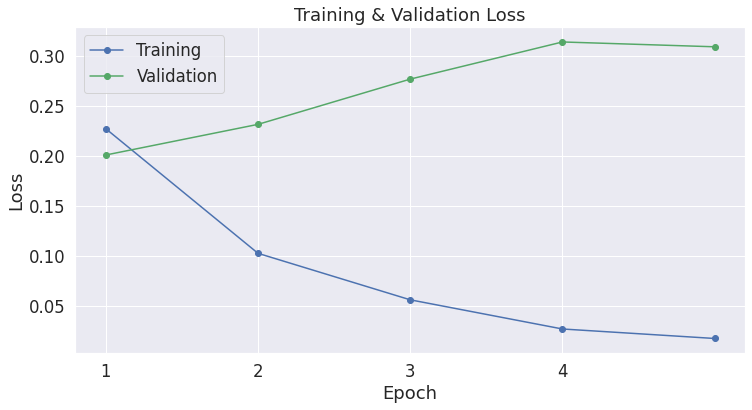

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# OPTIONS: CHECK MORE THAN 5 - 7
#  either cite a paper or test it


In [ ]:
np.argmax(logits, axis=1).flatten()

In [ ]:
logits = logits[0].detach().cpu().numpy()